In [1]:
import numpy as np 

In [7]:
# tensor with randomly generated entries, order 3, dims: 2-by-3-by-4
A = np.random.rand(2,3,4);
# identity matrix, order 2, dims: 5-by-5 
B = np.eye(5,5)
# tensor of 1's, order 4, dims: 2-by-4-by-2-by-4
C = np.ones((2,4,2,4))
# matrix of 0's, order 2, dims: 3-by-5
D = np.zeros((3,5));
# initialize complex random tensor
E = np.random.rand(2,3,4) + 1j*np.random.rand(2,3,4);

In [15]:
A = np.random.rand(2,3,4,5);
Atilde = np.transpose(A, [3,2,1,0]);
Atilde.shape

(5, 4, 3, 2)

In [16]:
B = np.random.rand(2,3,4);
Btilde = np.reshape(B,[2,12]);
Btilde.shape

(2, 12)

In [17]:
# reshape   transpose contraction
d = 5;
A = np.random.rand(d,d,d,d);
B = np.random.rand(d,d,d,d);
Ap = np.transpose(A, [0,2,1,3]);
Bp = np.transpose(B, [0,3,1,2]);
App = np.reshape(Ap, [d*d, d*d]);
Bpp = np.reshape(Bp, [d*d,d*d]);
Cpp = App@Bpp;
C = np.reshape(Cpp,[d,d,d,d]);

# ITEBD

In [1]:
import numpy as np 
from ncon import ncon 
import scipy.linalg as spl
import matplotlib.pyplot as plt

In [2]:
def Tens(d,D):
    Ga = np.random.rand(D,d,D)
#     Ga = Ga / np.max(np.abs(Ga))
    Gb = np.random.rand(D,d,D)
#     Gb = Gb / np.max(np.abs(Gb))
    La = np.random.rand(D); 
    La = La / np.trace(np.diag(La))
    Lb = np.random.rand(D)
    Lb = Lb / np.trace(np.diag(Lb))
    G = [Ga, Gb]
    L = [La, Lb]
    return G,L

In [3]:
def Ham(J,h,delta):
    X = np.array([[0,1],[1,0]])
    Id = np.eye(2,2)
    Z = np.array([[1,0],[0,-1]])
    Hz = ncon([Z,Z],[[-1,-3],[-2,-4]])
    Hx = 0.5*(ncon([X,Id],[[-1,-3],[-2,-4]]) + ncon([Id,X],[[-1,-3],[-2,-4]]))
    H = J*Hz - h*Hx
    Hexp = np.reshape(H,[4,4])
    Hexp = spl.expm(-delta*Hexp)
    Ug = np.reshape(Hexp, [2,2,2,2])
    Mag = ncon([Z,Z],[[-1,-3],[-2,-4]])
    return H, Ug, Mag

In [55]:
def Itebd(d,D,J,h,delta,n_iter):
    H, Ug, Mag = Ham(J,h,delta);
    G, L = Tens(d,D);
    tol = 1e-3
    θ = np.random.rand(D,d,D,d)
    nrm_θ = ncon([θ,θ.conj()], [[1,2,3,4],[1,2,3,4]])
    energy = ncon([θ,H,θ.conj()],[[1,2,3,4],[2,4,5,6],[1,5,3,6]]) / nrm_θ
    for step in range(n_iter):
        if step % 2 == 0:
            A = 0; B = 1;
        else:
            A = 1; B = 0;
        tensors = [np.diag(L[B]), G[A], np.diag(L[A]), G[B], np.diag(L[B])]
        connect = [[-1,1],[1,-2,2],[2,3],[3,-4,4],[4,-3]]
        θ_new = ncon(tensors, connect)
        nrm_θ_new = ncon([θ_new,θ_new.conj()], [[1,2,3,4],[1,2,3,4]])
        ground_energy = ncon([θ_new,H,θ_new.conj()],[[1,2,3,4],[2,4,5,6],[1,5,3,6]]) / nrm_θ_new

        if np.abs(ground_energy - energy) < tol:
#             print("Success!")
            break
#         print("step: {}, Enr: {}".format(step, energy))
        energy = ground_energy
        θ = ncon([θ_new, Ug],[[-1,1,-3,2],[1,2,-2,-4]])
        nrm_θ = ncon([θ,θ.conj()], [[1,2,3,4],[1,2,3,4]])
        θ = θ / nrm_θ 
        θ = np.reshape(θ,[D*d,d*D])
        U,S,V = np.linalg.svd(θ)
        G[A] = U[:,0:D];
        G[A] = np.reshape(G[A], [D,d,D])
        G[B] = V[0:D,:];
        G[B] = np.reshape(G[B], [D,d,D])
        L[A] = S[0:D] / np.trace(np.diag(S[0:D]))
        G[A] = ncon([np.diag(1./L[B]), G[A]],[[-1,1],[1,-2,-3]])
        G[B] = ncon([G[B], np.diag(1./L[B])],[[-1,-2,1],[1,-3]])
        G[A] = G[A] / np.max(np.abs(G[A]))
        G[B] = G[B] / np.max(np.abs(G[B]))
        
    M = []
    E = []
    for j in range(len(G)):
        if j % 2 == 0:
            A = 0; B = 1;
        else:
            A = 1; B = 0;
        tensors = [np.diag(L[B]), G[A], np.diag(L[A]), G[B], np.diag(L[B])]
        connect = [[-1,1],[1,-2,2],[2,3],[3,-4,4],[4,-3]]
        θ = ncon(tensors, connect)
        nrm_θ = ncon([θ,θ.conj()], [[1,2,3,4],[1,2,3,4]])
        m = ncon([θ,Mag,θ.conj()],[[1,2,3,4],[2,4,5,6],[1,5,3,6]]) / nrm_θ
        e = ncon([θ,H,θ.conj()],[[1,2,3,4],[2,4,5,6],[1,5,3,6]]) / nrm_θ 
        M.append(m)
        E.append(e)
    E_total = np.sum(E)
    E0 = E_total/2
    M0 = np.sum(M)/2
    return M0,E0

In [24]:
def Itebd2(d,D,J,h,delta,n_iter):
    H, Ug, Mag = Ham(J,h,delta);
    G, L = Tens(d,D);
    tol = 1e-1
#     θ2 = np.random.rand(D,d,D,d)
#     nrm_θ2 = ncon([θ2,θ2.conj()], [[1,2,3,4],[1,2,3,4]])
#     energy = ncon([θ2,H,θ2.conj()],[[1,2,3,4],[2,4,5,6],[1,5,3,6]]) / nrm_θ2
    
    
    for step in range(n_iter):
        if step % 2 == 0:
            A = 0; B = 1;
        else:
            A = 1; B = 0;
            
        tensors1 = [np.diag(L[B]), G[A], np.diag(L[A]), G[B], np.diag(L[B])]
        connect1 = [[-1,1],[1,-2,2],[2,3],[3,-4,4],[4,-3]]
        θ1 = ncon(tensors1, connect1)
        nrm_θ1 = ncon([θ1,θ1.conj()], [[1,2,3,4],[1,2,3,4]])
        e1 = ncon([θ1,H,θ1.conj()],[[1,2,3,4],[2,4,5,6],[1,5,3,6]]) / nrm_θ1
        
        tensors = [np.diag(L[B]), G[A], np.diag(L[A]),G[B],np.diag(L[B]),Ug]
        connect = [[-1,1],[1,2,3],[3,4],[4,5,6],[6,-3],[2,5,-2,-4]]
        θ = ncon(tensors, connect)
        nrm_θ = ncon([θ,θ.conj()], [[1,2,3,4],[1,2,3,4]])
        e0 = ncon([θ,H,θ.conj()],
                             [[1,2,3,4],[2,4,5,6],[1,5,3,6]])/ nrm_θ

        if np.abs(e0 - e1) < tol:
            print("Success!")
            break
        else:
            print("step: {}, Err: {}".format(step, np.abs(e0 - e1)))
            e1 = e0
            
#         tensors = [np.diag(L[B]), G[A], np.diag(L[A]),G[B],np.diag(L[B]),Ug]
#         connect = [[-1,1],[1,2,3],[3,4],[4,5,6],[6,-3],[2,5,-2,-4]]
#         θ = ncon(tensors, connect)
#         θ = ncon([θ, Ug],[[-1,1,-3,2],[1,2,-2,-4]])
#         nrm_θ = ncon([θ,θ.conj()], [[1,2,3,4],[1,2,3,4]])
#         θ = θ / nrm_θ 
        θ = np.reshape(θ,[D*d,d*D])
        U,S,V = np.linalg.svd(θ)
        G[A] = U[:,0:D]
        G[A] = np.reshape(G[A], [D,d,D])
        G[B] = V[0:D,:]
        G[B] = np.reshape(G[B], [D,d,D])
        L[A] = S[0:D] / np.trace(np.diag(S[0:D]))
        G[A] = ncon([np.diag(1./L[B]), G[A]],[[-1,1],[1,-2,-3]])
        G[B] = ncon([G[B], np.diag(1./L[B])],[[-1,-2,1],[1,-3]])
        G[A] = G[A] / np.max(np.abs(G[A]))
        G[B] = G[B] / np.max(np.abs(G[B]))
        
    M = []
    E = []
#     θ = np.reshape(θ,[D,d,D,d])
    for j in range(len(G)):
        if j % 2 == 0:
            A = 0; B = 1;
        else:
            A = 1; B = 0;
        tensors = [np.diag(L[B]), G[A], np.diag(L[A]), G[B], np.diag(L[B])]
        connect = [[-1,1],[1,-2,2],[2,3],[3,-4,4],[4,-3]]
        θ = ncon(tensors, connect)
        nrm_θ = ncon([θ,θ.conj()], [[1,2,3,4],[1,2,3,4]])
        m = ncon([θ,Mag,θ.conj()],[[1,2,3,4],[2,4,5,6],[1,5,3,6]]) / nrm_θ
        e = ncon([θ,H,θ.conj()],[[1,2,3,4],[2,4,5,6],[1,5,3,6]]) / nrm_θ 
        M.append(m)
        E.append(e)
    E_total = np.sum(E)
    E0 = E_total/2
    M0 = np.sum(M)/2
    return M0,E0

In [28]:
# Itebd(d,D,J,h,delta,n_iter) 
Itebd2(2,10,-1,-0.4,0.1,1000)

step: 0, Err: 0.2089259887465979
step: 1, Err: 0.21518143034760845
step: 2, Err: 0.16244414883122293
Success!


(0.998284335800637, -1.0099170125349475)

In [ ]:
# Itebd(d,D,J,h,delta,n_iter) 
E = []
M = []
x = np.arange(0,2,0.1)
# x = np.linspace(0,6,40)
for j in x:
    m, e = Itebd2(2,8,-1,j,0.1,4000)
    E.append(e)
    M.append(m)

step: 0, Err: 0.19679187829532954
step: 1, Err: 0.19892439355461788
step: 2, Err: 0.19915454716684253
Success!
step: 0, Err: 0.1930842444907146
step: 1, Err: 0.19183861455911766
step: 2, Err: 0.20002275259351138
Success!
step: 0, Err: 0.19304398224880642
step: 1, Err: 0.19638323682775147
step: 2, Err: 0.16909063553053544
Success!
step: 0, Err: 0.18640212499771702
step: 1, Err: 0.1776152398528998
Success!
step: 0, Err: 0.1881804658950878
step: 1, Err: 0.20723230976233534
step: 2, Err: 0.20305342997116324
Success!
step: 0, Err: 0.17965741767531906
step: 1, Err: 0.1693497556241269
step: 2, Err: 0.2248585747945236
Success!
step: 0, Err: 0.17933819928023897
step: 1, Err: 0.17422039089271524
step: 2, Err: 0.17477209612948957
Success!
step: 0, Err: 0.18231034134137558
step: 1, Err: 0.18347527793277663
step: 2, Err: 0.16238268919055054
Success!
step: 0, Err: 0.16995921993349017
step: 1, Err: 0.18317562393129705
step: 2, Err: 0.15157789379277986
Success!
step: 0, Err: 0.1684434320852567
step: 1

step: 112, Err: 0.15870475455138333
step: 113, Err: 0.15654141319310533
step: 114, Err: 0.16185707341440558
step: 115, Err: 0.1566821850130804
step: 116, Err: 0.1553574831242266
step: 117, Err: 0.16408163907141304
step: 118, Err: 0.14906649136039163
step: 119, Err: 0.1533316177969728
step: 120, Err: 0.19076780089172574
step: 121, Err: 0.15579491396255385
step: 122, Err: 0.13818603730380885
step: 123, Err: 0.11877826279438009
step: 124, Err: 0.1881268017307406
step: 125, Err: 0.15381869822889982
step: 126, Err: 0.171843314052206
step: 127, Err: 0.1549457885734089
step: 128, Err: 0.12779350116901078
step: 129, Err: 0.13082596595745533
step: 130, Err: 0.16005694732524467
step: 131, Err: 0.1696772244202578
step: 132, Err: 0.1293877910654475
step: 133, Err: 0.15573696586847174
step: 134, Err: 0.13726280837219185
step: 135, Err: 0.16203591704274345
step: 136, Err: 0.13667369672635798
step: 137, Err: 0.13403511511459487
step: 138, Err: 0.17484697119582693
step: 139, Err: 0.17431907775083766
s

step: 371, Err: 0.12991921164012532
step: 372, Err: 0.15300583140706814
step: 373, Err: 0.14605650575943807
step: 374, Err: 0.1663340096216912
step: 375, Err: 0.17593333769583963
step: 376, Err: 0.1450729264639512
step: 377, Err: 0.14943894550690895
step: 378, Err: 0.17219527183331818
step: 379, Err: 0.128187379631737
step: 380, Err: 0.149942913633609
step: 381, Err: 0.1399037923993396
step: 382, Err: 0.17630520584854592
step: 383, Err: 0.18902758022423471
step: 384, Err: 0.14628758744520742
step: 385, Err: 0.13075549712593437
step: 386, Err: 0.14208565243353144
step: 387, Err: 0.13020957518329146
step: 388, Err: 0.14227717359985115
step: 389, Err: 0.1398664156512155
step: 390, Err: 0.1442920319082177
step: 391, Err: 0.19159391095984424
step: 392, Err: 0.1569565055060509
step: 393, Err: 0.1514400677002934
step: 394, Err: 0.17187963644918014
step: 395, Err: 0.14342110909279837
step: 396, Err: 0.16452398079290886
step: 397, Err: 0.16063636545774918
step: 398, Err: 0.16316931952422364
ste

step: 621, Err: 0.14381972975565382
step: 622, Err: 0.15383633255901374
step: 623, Err: 0.13105195770147948
step: 624, Err: 0.15708189534370853
step: 625, Err: 0.15375476281229505
step: 626, Err: 0.1304176328329565
step: 627, Err: 0.15910198926914765
step: 628, Err: 0.13820003798100533
step: 629, Err: 0.14508662045785603
step: 630, Err: 0.16950697898577727
step: 631, Err: 0.15708387951402525
step: 632, Err: 0.1652095307318917
step: 633, Err: 0.16567357225950397
step: 634, Err: 0.1540838973830152
step: 635, Err: 0.14857336663704124
step: 636, Err: 0.14934762335955964
step: 637, Err: 0.1393844318363504
step: 638, Err: 0.17583560358300532
step: 639, Err: 0.16250495499571138
step: 640, Err: 0.13750789998135926
step: 641, Err: 0.13710279816978965
step: 642, Err: 0.1531859086412286
step: 643, Err: 0.1763270852805059
step: 644, Err: 0.15303888427528411
step: 645, Err: 0.14931288505857676
step: 646, Err: 0.15836858669851184
step: 647, Err: 0.14816234118025862
step: 648, Err: 0.1498445687113820

step: 885, Err: 0.16044611071886683
step: 886, Err: 0.15291747908198317
step: 887, Err: 0.13565632001728023
step: 888, Err: 0.17820194492351948
step: 889, Err: 0.16177704551204197
step: 890, Err: 0.17020764733841265
step: 891, Err: 0.20378665064530466
step: 892, Err: 0.1551550408182818
step: 893, Err: 0.15741593640832852
step: 894, Err: 0.17225874267318364
step: 895, Err: 0.18008600766909
step: 896, Err: 0.14496995957435455
step: 897, Err: 0.14934234540305602
step: 898, Err: 0.17375079524180648
step: 899, Err: 0.16197698966388874
step: 900, Err: 0.13657189764095445
step: 901, Err: 0.14422581621883457
step: 902, Err: 0.1450606439650428
step: 903, Err: 0.18502832820514448
step: 904, Err: 0.14086733707571408
step: 905, Err: 0.13352770556327442
step: 906, Err: 0.17956267138416449
step: 907, Err: 0.14279804575189803
step: 908, Err: 0.135388977918798
step: 909, Err: 0.13998673257079175
step: 910, Err: 0.14641188070257338
step: 911, Err: 0.12776938040423902
step: 912, Err: 0.15621936643465473

step: 1116, Err: 0.1327139419282224
step: 1117, Err: 0.15458154893694265
step: 1118, Err: 0.13343403093676698
step: 1119, Err: 0.18127431389071824
step: 1120, Err: 0.16627054776321537
step: 1121, Err: 0.1600591032015557
step: 1122, Err: 0.15064677688970507
step: 1123, Err: 0.1550113348170139
step: 1124, Err: 0.14282083649347355
step: 1125, Err: 0.13653038486627778
step: 1126, Err: 0.1822339048930346
step: 1127, Err: 0.16459682723974933
step: 1128, Err: 0.14593212944576006
step: 1129, Err: 0.17288852775538355
step: 1130, Err: 0.14363983557207471
step: 1131, Err: 0.17271800975961216
step: 1132, Err: 0.14513151189986417
step: 1133, Err: 0.15322703865987775
step: 1134, Err: 0.14265901330739172
step: 1135, Err: 0.15938452563012628
step: 1136, Err: 0.16133551157212178
step: 1137, Err: 0.16736099513250347
step: 1138, Err: 0.14928561302403187
step: 1139, Err: 0.16093333344134653
step: 1140, Err: 0.13126027483628122
step: 1141, Err: 0.17299739656370527
step: 1142, Err: 0.14533863213062248
step:

step: 1369, Err: 0.15357814906385236
step: 1370, Err: 0.18880687002440633
step: 1371, Err: 0.1743977799742673
step: 1372, Err: 0.15141315119922227
step: 1373, Err: 0.14498604244300894
step: 1374, Err: 0.16480121803624947
step: 1375, Err: 0.1640093977319761
step: 1376, Err: 0.15646011161182138
step: 1377, Err: 0.1507429951048629
step: 1378, Err: 0.14177982643985265
step: 1379, Err: 0.1605535352879104
step: 1380, Err: 0.14675047444209466
step: 1381, Err: 0.13113808110222136
step: 1382, Err: 0.1769237266362278
step: 1383, Err: 0.16610393435999415
step: 1384, Err: 0.14107986027794084
step: 1385, Err: 0.16307826675564918
step: 1386, Err: 0.1603597703013404
step: 1387, Err: 0.1600255878626129
step: 1388, Err: 0.13445093806860298
step: 1389, Err: 0.15818571870841946
step: 1390, Err: 0.16979334377494482
step: 1391, Err: 0.14910980374233818
step: 1392, Err: 0.16003672180590311
step: 1393, Err: 0.15784648391335954
step: 1394, Err: 0.1555403119304224
step: 1395, Err: 0.17479813510271325
step: 139

step: 1600, Err: 0.15250163701930108
step: 1601, Err: 0.16254447487890822
step: 1602, Err: 0.19384439474138193
step: 1603, Err: 0.17116209626196
step: 1604, Err: 0.16117918299674971
step: 1605, Err: 0.17977992624729988
step: 1606, Err: 0.1560934576826425
step: 1607, Err: 0.16742657664659144
step: 1608, Err: 0.17761764030809135
step: 1609, Err: 0.15033643466588043
step: 1610, Err: 0.14248015950680815
step: 1611, Err: 0.1491452623015468
step: 1612, Err: 0.1252087542199496
step: 1613, Err: 0.16017334495505708
step: 1614, Err: 0.14531516210565454
step: 1615, Err: 0.1542845910020363
step: 1616, Err: 0.133471954024464
step: 1617, Err: 0.18262655326408272
step: 1618, Err: 0.1546168824566463
step: 1619, Err: 0.14468646681799524
step: 1620, Err: 0.15705463530080044
step: 1621, Err: 0.1596357370239896
step: 1622, Err: 0.18706104505063492
step: 1623, Err: 0.16609683623426652
step: 1624, Err: 0.14163408230810948
step: 1625, Err: 0.154275794745675
step: 1626, Err: 0.16641006552945004
step: 1627, Er

step: 1858, Err: 0.17926098121172496
step: 1859, Err: 0.15031605003233195
step: 1860, Err: 0.12783828173765577
step: 1861, Err: 0.18099312964373815
step: 1862, Err: 0.14021552130953174
step: 1863, Err: 0.14618568606263227
step: 1864, Err: 0.19068329421268115
step: 1865, Err: 0.14676872956027376
step: 1866, Err: 0.1641621185301383
step: 1867, Err: 0.1564807190118629
step: 1868, Err: 0.14845153470822559
step: 1869, Err: 0.17149916910620822
step: 1870, Err: 0.16211884291819545
step: 1871, Err: 0.1773214420254987
step: 1872, Err: 0.1688556013907141
step: 1873, Err: 0.15621080144475097
step: 1874, Err: 0.14605029357328192
step: 1875, Err: 0.17813113847076711
step: 1876, Err: 0.14666637866862486
step: 1877, Err: 0.1445791086783157
step: 1878, Err: 0.15303940297612995
step: 1879, Err: 0.1341671222248373
step: 1880, Err: 0.1397458305400121
step: 1881, Err: 0.13522960355564884
step: 1882, Err: 0.1375809902292049
step: 1883, Err: 0.19218516699635624
step: 1884, Err: 0.15796600902007918
step: 188

step: 2082, Err: 0.15567252194435754
step: 2083, Err: 0.16179256204793835
step: 2084, Err: 0.14818240332030053
step: 2085, Err: 0.15599343442580493
step: 2086, Err: 0.1790892665855639
step: 2087, Err: 0.147827972310985
step: 2088, Err: 0.14090159880689246
step: 2089, Err: 0.1434271926534838
step: 2090, Err: 0.16505574052745264
step: 2091, Err: 0.15908044327392123
step: 2092, Err: 0.14483575776690638
step: 2093, Err: 0.14960085749142182
step: 2094, Err: 0.12858931737234935
step: 2095, Err: 0.14698428671275887
step: 2096, Err: 0.12636042334073472
step: 2097, Err: 0.14553068703547845
step: 2098, Err: 0.16469942999428033
step: 2099, Err: 0.16512630734773315
step: 2100, Err: 0.18333983522444663
step: 2101, Err: 0.18081251558285105
step: 2102, Err: 0.16402903484579157
step: 2103, Err: 0.1554947498937571
step: 2104, Err: 0.1415550605198228
step: 2105, Err: 0.14718336066342919
step: 2106, Err: 0.15844359293307742
step: 2107, Err: 0.16048884340889824
step: 2108, Err: 0.12636467237365268
step: 2

step: 2309, Err: 0.13558789702493979
step: 2310, Err: 0.13220798354689256
step: 2311, Err: 0.14814623858837583
step: 2312, Err: 0.16062779823055795
step: 2313, Err: 0.16232114541486897
step: 2314, Err: 0.1569886561784033
step: 2315, Err: 0.13843298706077745
step: 2316, Err: 0.13400288171620356
step: 2317, Err: 0.14545399970694728
step: 2318, Err: 0.154565878814225
step: 2319, Err: 0.14117838080144773
step: 2320, Err: 0.1554563155054789
step: 2321, Err: 0.1438637720233651
step: 2322, Err: 0.1580202946464333
step: 2323, Err: 0.13195144530681002
step: 2324, Err: 0.18495013475633781
step: 2325, Err: 0.13741789526242942
step: 2326, Err: 0.16027273971003542
step: 2327, Err: 0.15325814682155703
step: 2328, Err: 0.1420064328788999
step: 2329, Err: 0.1735915432086388
step: 2330, Err: 0.20527286986315463
step: 2331, Err: 0.15322323653358194
step: 2332, Err: 0.165804565404716
step: 2333, Err: 0.13416676917026416
step: 2334, Err: 0.1827410839055934
step: 2335, Err: 0.1547925576267013
step: 2336, E

step: 2564, Err: 0.13338270998740787
step: 2565, Err: 0.1290205973862797
step: 2566, Err: 0.14960375475605892
step: 2567, Err: 0.16278675761096362
step: 2568, Err: 0.1391213234421529
step: 2569, Err: 0.12348492503382835
step: 2570, Err: 0.15914215845377
step: 2571, Err: 0.1531076967259728
step: 2572, Err: 0.15659798782435574
step: 2573, Err: 0.16858403867073446
step: 2574, Err: 0.16469157920414879
step: 2575, Err: 0.18073164771653727
step: 2576, Err: 0.15795089631436743
step: 2577, Err: 0.1515009990255849
step: 2578, Err: 0.14942126630912034
step: 2579, Err: 0.1455154200878861
step: 2580, Err: 0.156174683461213
step: 2581, Err: 0.161256759249512
step: 2582, Err: 0.14703117594700976
step: 2583, Err: 0.15738371230913217
step: 2584, Err: 0.17584116815389628
step: 2585, Err: 0.1594497985463137
step: 2586, Err: 0.16251981863030585
step: 2587, Err: 0.17869327033520932
step: 2588, Err: 0.13279623660297135
step: 2589, Err: 0.13429006708560376
step: 2590, Err: 0.13411534872012743
step: 2591, Er

step: 2810, Err: 0.15369646578174545
step: 2811, Err: 0.17817658788608082
step: 2812, Err: 0.13991399417819328
step: 2813, Err: 0.14582862516474493
step: 2814, Err: 0.12146689925577947
step: 2815, Err: 0.13042679306050053
step: 2816, Err: 0.10462925829372849
step: 2817, Err: 0.11008830318385732
step: 2818, Err: 0.1414545028158618
step: 2819, Err: 0.14085728058943814
step: 2820, Err: 0.14451698565989024
step: 2821, Err: 0.15372286799112
step: 2822, Err: 0.14425595860672003
step: 2823, Err: 0.12435228949142285
step: 2824, Err: 0.17069771178203652
step: 2825, Err: 0.13886836952986115
step: 2826, Err: 0.15635003682154558
step: 2827, Err: 0.16445462234430486
step: 2828, Err: 0.1488132171007659
step: 2829, Err: 0.16886258305485913
step: 2830, Err: 0.14941403613612003
step: 2831, Err: 0.15945668294891346
step: 2832, Err: 0.15964121780728924
step: 2833, Err: 0.1340741618712098
step: 2834, Err: 0.17142764133426702
step: 2835, Err: 0.15410740095444186
step: 2836, Err: 0.14345189118303248
step: 2

step: 3039, Err: 0.14761694910554435
step: 3040, Err: 0.1536147524440603
step: 3041, Err: 0.1598291926348374
step: 3042, Err: 0.1521234008385164
step: 3043, Err: 0.16465300038623365
step: 3044, Err: 0.14105770844253085
step: 3045, Err: 0.15577875128748553
step: 3046, Err: 0.12735397614899413
step: 3047, Err: 0.142785956439881
step: 3048, Err: 0.1240474247467489
step: 3049, Err: 0.1577891753170937
step: 3050, Err: 0.17112199794085425
step: 3051, Err: 0.16642225817749767
step: 3052, Err: 0.1511344946923605
step: 3053, Err: 0.1556341095335818
step: 3054, Err: 0.166792971139609
step: 3055, Err: 0.16398966359063882
step: 3056, Err: 0.13766883556461407
step: 3057, Err: 0.1690737606646373
step: 3058, Err: 0.16091079810127562
step: 3059, Err: 0.15391271386970495
step: 3060, Err: 0.1481051193924361
step: 3061, Err: 0.1594410154900301
step: 3062, Err: 0.1478467952731768
step: 3063, Err: 0.14940641612834948
step: 3064, Err: 0.15600866681055559
step: 3065, Err: 0.1402661731339614
step: 3066, Err: 

step: 3276, Err: 0.12988538471655864
step: 3277, Err: 0.1683149955059997
step: 3278, Err: 0.15782588006082787
step: 3279, Err: 0.145080840058587
step: 3280, Err: 0.1345099228315323
step: 3281, Err: 0.15610039269749643
step: 3282, Err: 0.15504314145645526
step: 3283, Err: 0.21573767067155913
step: 3284, Err: 0.1592755212665924
step: 3285, Err: 0.13788980126847927
step: 3286, Err: 0.1469438296212291
step: 3287, Err: 0.14093650395384816
step: 3288, Err: 0.16490467840199474
step: 3289, Err: 0.12815265728848635
step: 3290, Err: 0.12838811836440778
step: 3291, Err: 0.13477448693537064
step: 3292, Err: 0.1655757559144717
step: 3293, Err: 0.14388636499079666
step: 3294, Err: 0.15603695897617675
step: 3295, Err: 0.1381763686196369
step: 3296, Err: 0.15295055211500141
step: 3297, Err: 0.160599664440354
step: 3298, Err: 0.16740546144117552
step: 3299, Err: 0.16873911709444545
step: 3300, Err: 0.14072433555470498
step: 3301, Err: 0.1419713666760416
step: 3302, Err: 0.15812550511081302
step: 3303, 

step: 3507, Err: 0.17109064042868272
step: 3508, Err: 0.18101776040019124
step: 3509, Err: 0.15374000184554082
step: 3510, Err: 0.16942951075547796
step: 3511, Err: 0.1468966309403097
step: 3512, Err: 0.14320589434454067
step: 3513, Err: 0.16261997506508186
step: 3514, Err: 0.1795421072685135
step: 3515, Err: 0.1587638241029885
step: 3516, Err: 0.16925753677066302
step: 3517, Err: 0.13988705545177282
step: 3518, Err: 0.13743817472959496
step: 3519, Err: 0.1631850263306649
step: 3520, Err: 0.14188416027730244
step: 3521, Err: 0.12308041693317495
step: 3522, Err: 0.14971436712057384
step: 3523, Err: 0.1410346933561395
step: 3524, Err: 0.14251034476570323
step: 3525, Err: 0.14420443487293477
step: 3526, Err: 0.1409524623430507
step: 3527, Err: 0.17103626662805205
step: 3528, Err: 0.1792239867009633
step: 3529, Err: 0.14508655741235454
step: 3530, Err: 0.16989720190961521
step: 3531, Err: 0.14831090607914588
step: 3532, Err: 0.16272554938991068
step: 3533, Err: 0.14790059107995024
step: 35

step: 3744, Err: 0.15857624233477674
step: 3745, Err: 0.1321015557075007
step: 3746, Err: 0.14334008931846887
step: 3747, Err: 0.1446550222864822
step: 3748, Err: 0.16928381428292627
step: 3749, Err: 0.14662593210696695
step: 3750, Err: 0.15377625517205074
step: 3751, Err: 0.15777990599113023
step: 3752, Err: 0.16152789895953212
step: 3753, Err: 0.18682352435742944
step: 3754, Err: 0.15946868593808028
step: 3755, Err: 0.14670073791161053
step: 3756, Err: 0.1778165142629724
step: 3757, Err: 0.14942412445721387
step: 3758, Err: 0.1397445022391559
step: 3759, Err: 0.17401741888109856
step: 3760, Err: 0.1659108251399697
step: 3761, Err: 0.1383567331286728
step: 3762, Err: 0.16850700936677354
step: 3763, Err: 0.13180364207444462
step: 3764, Err: 0.1537294179466724
step: 3765, Err: 0.1646505209149125
step: 3766, Err: 0.14807655074222104
step: 3767, Err: 0.13200805335847998
step: 3768, Err: 0.15127537821674997
step: 3769, Err: 0.13573115375644518
step: 3770, Err: 0.14359295481545642
step: 377

step: 3989, Err: 0.16666817724309912
step: 3990, Err: 0.168440859357194
step: 3991, Err: 0.1438955473211887
step: 3992, Err: 0.15410801007015773
step: 3993, Err: 0.16266791510097844
step: 3994, Err: 0.1608281594702643
step: 3995, Err: 0.1345074564556641
step: 3996, Err: 0.13726905980767712
step: 3997, Err: 0.16017257842961352
step: 3998, Err: 0.16382951469264584
step: 3999, Err: 0.15978125558144907
step: 0, Err: 0.1703497833329568
step: 1, Err: 0.13218512045237207
step: 2, Err: 0.3957697293294206
step: 3, Err: 0.14833808503419643
step: 4, Err: 0.18842850264826816
step: 5, Err: 0.16976515229164524
step: 6, Err: 0.18745902888664112
step: 7, Err: 0.18468898232052733
step: 8, Err: 0.12547791943305175
step: 9, Err: 0.14136905206084815
step: 10, Err: 0.1577264453887124
step: 11, Err: 0.15132051556801862
step: 12, Err: 0.17768071447736977
step: 13, Err: 0.15014707614805634
step: 14, Err: 0.13886364202921264
step: 15, Err: 0.19097227206749134
step: 16, Err: 0.2130905417083434
step: 17, Err: 0.

step: 239, Err: 0.2328303754532839
step: 240, Err: 0.15132624947845197
step: 241, Err: 0.16071759858357515
step: 242, Err: 0.17226804539341645
step: 243, Err: 0.17175650625378958
step: 244, Err: 0.15788463518254314
step: 245, Err: 0.18055050245596727
step: 246, Err: 0.16579747475764828
step: 247, Err: 0.14982805095174667
step: 248, Err: 0.16855948210886829
step: 249, Err: 0.16233198157969242
step: 250, Err: 0.14292810987421878
step: 251, Err: 0.19503817483954666
step: 252, Err: 0.1753560473895044
step: 253, Err: 0.16587900071745443
step: 254, Err: 0.16451678233702127
step: 255, Err: 0.17099100276692591
step: 256, Err: 0.2184774477548116
step: 257, Err: 0.16303213515383108
step: 258, Err: 0.17505513485298718
step: 259, Err: 0.15394875888787674
step: 260, Err: 0.18389524946131042
step: 261, Err: 0.18232892529487255
step: 262, Err: 0.1999703173163987
step: 263, Err: 0.1926567074543568
step: 264, Err: 0.1882889784844901
step: 265, Err: 0.18793788934427802
step: 266, Err: 0.1916380098333032

step: 511, Err: 0.15640965866927048
step: 512, Err: 0.1788304264897509
step: 513, Err: 0.1727679194942806
step: 514, Err: 0.1638872573703809
step: 515, Err: 0.17521061717050856
step: 516, Err: 0.20638380318759952
step: 517, Err: 0.17861270538553975
step: 518, Err: 0.16680584771609452
step: 519, Err: 0.15486642143274199
step: 520, Err: 0.1625008581661307
step: 521, Err: 0.1721803400851205
step: 522, Err: 0.181171423421842
step: 523, Err: 0.15495105005693177
step: 524, Err: 0.1787632630558844
step: 525, Err: 0.2164263752860377
step: 526, Err: 0.16283157552595262
step: 527, Err: 0.17924198748622766
step: 528, Err: 0.15157547018738238
step: 529, Err: 0.183942967422547
step: 530, Err: 0.19953641336143324
step: 531, Err: 0.19738655480200595
step: 532, Err: 0.1791490922899932
step: 533, Err: 0.19291317566708788
step: 534, Err: 0.1774287333804725
step: 535, Err: 0.18210214010438253
step: 536, Err: 0.19021212868875748
step: 537, Err: 0.19926265405944643
step: 538, Err: 0.16517981258700898
step:

step: 781, Err: 0.15358290407944164
step: 782, Err: 0.16919171494317697
step: 783, Err: 0.16666752021968168
step: 784, Err: 0.19189729559579227
step: 785, Err: 0.162225345769331
step: 786, Err: 0.17273286540096633
step: 787, Err: 0.1536230441873203
step: 788, Err: 0.2064457164494795
step: 789, Err: 0.19572891202834297
step: 790, Err: 0.1766309184327033
step: 791, Err: 0.2062485588327314
step: 792, Err: 0.1896078706255211
step: 793, Err: 0.20216361613290146
step: 794, Err: 0.17176047758522195
step: 795, Err: 0.21877771218099062
step: 796, Err: 0.1955348829445689
step: 797, Err: 0.15420115927844558
step: 798, Err: 0.16642959265013046
step: 799, Err: 0.16114316519385263
step: 800, Err: 0.20343416224890887
step: 801, Err: 0.17784873164502724
step: 802, Err: 0.16171282583194602
step: 803, Err: 0.1522729203744433
step: 804, Err: 0.15067646786179512
step: 805, Err: 0.13835772434653815
step: 806, Err: 0.14893255886352152
step: 807, Err: 0.17103353568586166
step: 808, Err: 0.17081106723067485
s

step: 1032, Err: 0.17831238883666556
step: 1033, Err: 0.13523432519399647
step: 1034, Err: 0.16582726186553964
step: 1035, Err: 0.16360057643042403
step: 1036, Err: 0.1795186759614027
step: 1037, Err: 0.18683845068754223
step: 1038, Err: 0.1874116644501005
step: 1039, Err: 0.2216319192950097
step: 1040, Err: 0.16503547658806395
step: 1041, Err: 0.1925012120054772
step: 1042, Err: 0.16684065173454043
step: 1043, Err: 0.19806299141008643
step: 1044, Err: 0.18816637645122802
step: 1045, Err: 0.16024975099385808
step: 1046, Err: 0.1533050186200673
step: 1047, Err: 0.15596231957730122
step: 1048, Err: 0.2014485067497156
step: 1049, Err: 0.2108870551104305
step: 1050, Err: 0.16636310543104127
step: 1051, Err: 0.1802071299575554
step: 1052, Err: 0.18264075322089113
step: 1053, Err: 0.18352557806357517
step: 1054, Err: 0.15399310223055296
step: 1055, Err: 0.14758018715720178
step: 1056, Err: 0.13976522950108605
step: 1057, Err: 0.1737257370980101
step: 1058, Err: 0.22278960308614537
step: 1059

step: 1267, Err: 0.1632225908290197
step: 1268, Err: 0.17514381399388723
step: 1269, Err: 0.19823174605883231
step: 1270, Err: 0.20009680796435747
step: 1271, Err: 0.16982223784834538
step: 1272, Err: 0.1830183923677129
step: 1273, Err: 0.18548816284941316
step: 1274, Err: 0.18114193979480753
step: 1275, Err: 0.21179962034554212
step: 1276, Err: 0.18506630094195464
step: 1277, Err: 0.17899859561911802
step: 1278, Err: 0.17702806798917714
step: 1279, Err: 0.15450817316650944
step: 1280, Err: 0.15102996355977094
step: 1281, Err: 0.17958470850160535
step: 1282, Err: 0.1916451602625322
step: 1283, Err: 0.23460579065491904
step: 1284, Err: 0.1531840386276857
step: 1285, Err: 0.17913676075031093
step: 1286, Err: 0.1918736885842125
step: 1287, Err: 0.17958433471756008
step: 1288, Err: 0.18197545008684202
step: 1289, Err: 0.17095324781508103
step: 1290, Err: 0.16292740953635487
step: 1291, Err: 0.1799218629485544
step: 1292, Err: 0.16899226702079284
step: 1293, Err: 0.14973917567578443
step: 1

step: 1510, Err: 0.1669884923327014
step: 1511, Err: 0.18682754054215245
step: 1512, Err: 0.2176883395653474
step: 1513, Err: 0.16391205469388925
step: 1514, Err: 0.15845803009024495
step: 1515, Err: 0.16270217942726317
step: 1516, Err: 0.16729385945392505
step: 1517, Err: 0.15181385981086204
step: 1518, Err: 0.18098638193363548
step: 1519, Err: 0.16637799731009784
step: 1520, Err: 0.18554081080881923
step: 1521, Err: 0.1992721398632218
step: 1522, Err: 0.1666060443187749
step: 1523, Err: 0.1567787206700153
step: 1524, Err: 0.15625824802937238
step: 1525, Err: 0.15671941250810084
step: 1526, Err: 0.16015765005996485
step: 1527, Err: 0.1592097048099248
step: 1528, Err: 0.14572304896448962
step: 1529, Err: 0.12823462255028906
step: 1530, Err: 0.2194912950392407
step: 1531, Err: 0.16816240719201558
step: 1532, Err: 0.1791582590520815
step: 1533, Err: 0.17034766072792729
step: 1534, Err: 0.17046264220200014
step: 1535, Err: 0.15619323581656408
step: 1536, Err: 0.17858641324102398
step: 153

step: 1757, Err: 0.22974358314041954
step: 1758, Err: 0.20659698320600328
step: 1759, Err: 0.20640736610943988
step: 1760, Err: 0.1830968351028075
step: 1761, Err: 0.17103921922117604
step: 1762, Err: 0.2025381912428894
step: 1763, Err: 0.19908186796658534
step: 1764, Err: 0.17341169943976498
step: 1765, Err: 0.163870269167397
step: 1766, Err: 0.16392944848466917
step: 1767, Err: 0.14095347604704944
step: 1768, Err: 0.1467786566664704
step: 1769, Err: 0.1737715659021486
step: 1770, Err: 0.1679458884066789
step: 1771, Err: 0.14363705442712726
step: 1772, Err: 0.1831058238061587
step: 1773, Err: 0.17694657905952704
step: 1774, Err: 0.154201440014905
step: 1775, Err: 0.14254098764712841
step: 1776, Err: 0.1891939218329639
step: 1777, Err: 0.16365173865106475
step: 1778, Err: 0.18255237723062812
step: 1779, Err: 0.1644335487323627
step: 1780, Err: 0.18606020110659527
step: 1781, Err: 0.2002591327591159
step: 1782, Err: 0.17471319660034546
step: 1783, Err: 0.15915715635756778
step: 1784, Er

step: 2016, Err: 0.18028419328645984
step: 2017, Err: 0.2094948937337422
step: 2018, Err: 0.17718496513430604
step: 2019, Err: 0.1887031503159442
step: 2020, Err: 0.1823955655913836
step: 2021, Err: 0.1800715620157487
step: 2022, Err: 0.17792927851230833
step: 2023, Err: 0.17524830460634266
step: 2024, Err: 0.1893047142519828
step: 2025, Err: 0.16941964115713315
step: 2026, Err: 0.1745476430705395
step: 2027, Err: 0.1757038428067843
step: 2028, Err: 0.18199812707998975
step: 2029, Err: 0.18415876358724192
step: 2030, Err: 0.16166269161483782
step: 2031, Err: 0.1562835151942641
step: 2032, Err: 0.17372612842157942
step: 2033, Err: 0.17439094584006787
step: 2034, Err: 0.18769414752863778
step: 2035, Err: 0.16925186222595423
step: 2036, Err: 0.1883440278246793
step: 2037, Err: 0.18408687995112127
step: 2038, Err: 0.17066412962691024
step: 2039, Err: 0.1577436502815439
step: 2040, Err: 0.195216183626717
step: 2041, Err: 0.21986814474881666
step: 2042, Err: 0.17106660954448238
step: 2043, E

step: 2272, Err: 0.1729670279078197
step: 2273, Err: 0.1593577681492182
step: 2274, Err: 0.1521420623408436
step: 2275, Err: 0.1598721972384436
step: 2276, Err: 0.21531089630301292
step: 2277, Err: 0.1888580519729579
step: 2278, Err: 0.15811675890183907
step: 2279, Err: 0.15425519293677703
step: 2280, Err: 0.21098509035689306
step: 2281, Err: 0.18232390153929567
step: 2282, Err: 0.15494117567627996
step: 2283, Err: 0.14942402482036998
step: 2284, Err: 0.2133227096964907
step: 2285, Err: 0.18151603431018137
step: 2286, Err: 0.1899682186737115
step: 2287, Err: 0.17097348305345061
step: 2288, Err: 0.19436740216205006
step: 2289, Err: 0.1817093215975989
step: 2290, Err: 0.18497531703217063
step: 2291, Err: 0.1880553219633574
step: 2292, Err: 0.20389721096280966
step: 2293, Err: 0.1532945150593077
step: 2294, Err: 0.16039578412235755
step: 2295, Err: 0.13487313057064831
step: 2296, Err: 0.2252065216320961
step: 2297, Err: 0.15436481264914415
step: 2298, Err: 0.1528380204309041
step: 2299, E

step: 2507, Err: 0.1880327048282633
step: 2508, Err: 0.15083974116457188
step: 2509, Err: 0.17771488423252602
step: 2510, Err: 0.17262883089875358
step: 2511, Err: 0.1729975956305414
step: 2512, Err: 0.20330143879404305
step: 2513, Err: 0.20696061938755017
step: 2514, Err: 0.16608368730850964
step: 2515, Err: 0.18221580994225528
step: 2516, Err: 0.1362064673436123
step: 2517, Err: 0.15145283330925663
step: 2518, Err: 0.17194061864081212
step: 2519, Err: 0.17767237898689925
step: 2520, Err: 0.16343252875537084
step: 2521, Err: 0.18365128481523385
step: 2522, Err: 0.15357797923082273
step: 2523, Err: 0.18004215499616283
step: 2524, Err: 0.16185978757766506
step: 2525, Err: 0.17444629956994073
step: 2526, Err: 0.1814287774539396
step: 2527, Err: 0.1794810392419548
step: 2528, Err: 0.18070474093804156
step: 2529, Err: 0.16412583798071356
step: 2530, Err: 0.17350256587812973
step: 2531, Err: 0.19230561400556434
step: 2532, Err: 0.1824386253404391
step: 2533, Err: 0.1774010050908481
step: 25

step: 2731, Err: 0.1844625907525148
step: 2732, Err: 0.17231540362424824
step: 2733, Err: 0.17048319381348653
step: 2734, Err: 0.16256661848390674
step: 2735, Err: 0.15109632890133384
step: 2736, Err: 0.15409544007874643
step: 2737, Err: 0.1875165826302565
step: 2738, Err: 0.159050606744368
step: 2739, Err: 0.19955854063403256
step: 2740, Err: 0.17990314999670387
step: 2741, Err: 0.15975963801590387
step: 2742, Err: 0.22319000155797253
step: 2743, Err: 0.1842009605164332
step: 2744, Err: 0.13338546692173958
step: 2745, Err: 0.16377136328417885
step: 2746, Err: 0.16411562043791128
step: 2747, Err: 0.19031349522161722
step: 2748, Err: 0.18189887568212582
step: 2749, Err: 0.18343028225473113
step: 2750, Err: 0.16405699435136545
step: 2751, Err: 0.16478338950131843
step: 2752, Err: 0.17612895016948094
step: 2753, Err: 0.15549628932984416
step: 2754, Err: 0.1503342858047818
step: 2755, Err: 0.1933765148267621
step: 2756, Err: 0.16492989688594428
step: 2757, Err: 0.17590325480344937
step: 27

step: 2967, Err: 0.15112393003044455
step: 2968, Err: 0.16304867845789928
step: 2969, Err: 0.15884361289056947
step: 2970, Err: 0.1742610741371884
step: 2971, Err: 0.2176848238055037
step: 2972, Err: 0.16022887737039215
step: 2973, Err: 0.1738248389335595
step: 2974, Err: 0.17799297088489108
step: 2975, Err: 0.18155813707674073
step: 2976, Err: 0.1530381395811884
step: 2977, Err: 0.17529460878857894
step: 2978, Err: 0.1929196312710999
step: 2979, Err: 0.16813274387579713
step: 2980, Err: 0.1682015738424676
step: 2981, Err: 0.16524704470611717
step: 2982, Err: 0.23450791598883214
step: 2983, Err: 0.18779328105629522
step: 2984, Err: 0.1718722036304563
step: 2985, Err: 0.17287384216263613
step: 2986, Err: 0.1620144253343323
step: 2987, Err: 0.21368276596253288
step: 2988, Err: 0.2079736508701473
step: 2989, Err: 0.1763307120007409
step: 2990, Err: 0.13797306008082288
step: 2991, Err: 0.2100503691424095
step: 2992, Err: 0.17120602180914735
step: 2993, Err: 0.1397984190003576
step: 2994, E

step: 3206, Err: 0.16233522582292115
step: 3207, Err: 0.15461863150585375
step: 3208, Err: 0.16875734721073332
step: 3209, Err: 0.16653607653955627
step: 3210, Err: 0.15734885552105538
step: 3211, Err: 0.17093913181358444
step: 3212, Err: 0.1710126823368865
step: 3213, Err: 0.15238684603177055
step: 3214, Err: 0.16344464831879946
step: 3215, Err: 0.1872013157504251
step: 3216, Err: 0.14373210834673045
step: 3217, Err: 0.16850709051291535
step: 3218, Err: 0.17582700769033188
step: 3219, Err: 0.18382542337568197
step: 3220, Err: 0.17689075264377307
step: 3221, Err: 0.16797563991632058
step: 3222, Err: 0.2064100411766927
step: 3223, Err: 0.17300765961907505
step: 3224, Err: 0.1410475002637166
step: 3225, Err: 0.1686901477019367
step: 3226, Err: 0.16129257818734155
step: 3227, Err: 0.1592386369670009
step: 3228, Err: 0.17145229116691607
step: 3229, Err: 0.129199187315008
step: 3230, Err: 0.2056808239850778
step: 3231, Err: 0.17040628940930191
step: 3232, Err: 0.18679601482479957
step: 3233

step: 3459, Err: 0.1812779399098019
step: 3460, Err: 0.16102372597215342
step: 3461, Err: 0.19090339891604646
step: 3462, Err: 0.21821699003872586
step: 3463, Err: 0.20011643923868871
step: 3464, Err: 0.1836877949245428
step: 3465, Err: 0.18421484910093144
step: 3466, Err: 0.18849991319558046
step: 3467, Err: 0.17449555232705838
step: 3468, Err: 0.1594636530882061
step: 3469, Err: 0.19539446807102934
step: 3470, Err: 0.18281496050550894
step: 3471, Err: 0.1588352542945608
step: 3472, Err: 0.15993946805124337
step: 3473, Err: 0.15725543040596968
step: 3474, Err: 0.19662639637334323
step: 3475, Err: 0.18307946859003343
step: 3476, Err: 0.1854756385973011
step: 3477, Err: 0.16912047326583246
step: 3478, Err: 0.19131097046360312
step: 3479, Err: 0.16795851467231726
step: 3480, Err: 0.17572977574325654
step: 3481, Err: 0.16203638494636818
step: 3482, Err: 0.17968297826501933
step: 3483, Err: 0.16248604646376674
step: 3484, Err: 0.1802297876010832
step: 3485, Err: 0.155644614838383
step: 348

step: 3705, Err: 0.1659196898098485
step: 3706, Err: 0.17679014823690298
step: 3707, Err: 0.17470335171882767
step: 3708, Err: 0.1785846419637629
step: 3709, Err: 0.1435116488266308
step: 3710, Err: 0.18186275899338122
step: 3711, Err: 0.16489231893238387
step: 3712, Err: 0.15561869646102955
step: 3713, Err: 0.16463267014675353
step: 3714, Err: 0.1636885633210139
step: 3715, Err: 0.16048163166664753
step: 3716, Err: 0.21166968005403797
step: 3717, Err: 0.2109970029209639
step: 3718, Err: 0.18328278324128222
step: 3719, Err: 0.16048412827458747
step: 3720, Err: 0.17060943847860943
step: 3721, Err: 0.1656012233009021
step: 3722, Err: 0.1524683992597553
step: 3723, Err: 0.16315473466646835
step: 3724, Err: 0.19086674617113597
step: 3725, Err: 0.1691782747913353
step: 3726, Err: 0.18946075921864258
step: 3727, Err: 0.24538876582678548
step: 3728, Err: 0.17391540244995074
step: 3729, Err: 0.187472107493164
step: 3730, Err: 0.17308497003047107
step: 3731, Err: 0.18034827554416077
step: 3732,

step: 3951, Err: 0.1618562947491009
step: 3952, Err: 0.15347694217190266
step: 3953, Err: 0.16859145196119973
step: 3954, Err: 0.14222050002020659
step: 3955, Err: 0.17719591603770324
step: 3956, Err: 0.15306194439980603
step: 3957, Err: 0.14242409397732603
step: 3958, Err: 0.1545744192376599
step: 3959, Err: 0.1702526978425869
step: 3960, Err: 0.20095876442218175
step: 3961, Err: 0.1740874653720108
step: 3962, Err: 0.16754594895452923
step: 3963, Err: 0.21404481496283845
step: 3964, Err: 0.18158109221243057
step: 3965, Err: 0.21236307878172422
step: 3966, Err: 0.17602582977835501
step: 3967, Err: 0.17848173784582877
step: 3968, Err: 0.1776461461708183
step: 3969, Err: 0.17387467232333909
step: 3970, Err: 0.15664866152099366
step: 3971, Err: 0.1565902767514371
step: 3972, Err: 0.1657679029882393
step: 3973, Err: 0.22223685363371992
step: 3974, Err: 0.1921294623983847
step: 3975, Err: 0.17220834131924145
step: 3976, Err: 0.16446086218666456
step: 3977, Err: 0.16093198737828596
step: 397

step: 209, Err: 0.21045440764166057
step: 210, Err: 0.19351482975931455
step: 211, Err: 0.18392642238283674
step: 212, Err: 0.18742453914381563
step: 213, Err: 0.2466248827665548
step: 214, Err: 0.21278935803333132
step: 215, Err: 0.21045371692938808
step: 216, Err: 0.20281128811024618
step: 217, Err: 0.21833861733750548
step: 218, Err: 0.2160121431135431
step: 219, Err: 0.19164373928751055
step: 220, Err: 0.1786651636214136
step: 221, Err: 0.19403955481912183
step: 222, Err: 0.22851271432562026
step: 223, Err: 0.1934746235739031
step: 224, Err: 0.1887749340658933
step: 225, Err: 0.19452760144535408
step: 226, Err: 0.16705168105023072
step: 227, Err: 0.2186976822928457
step: 228, Err: 0.227615629374599
step: 229, Err: 0.19539118936427746
step: 230, Err: 0.20115421197389538
step: 231, Err: 0.17911188010113177
step: 232, Err: 0.19396879454226723
step: 233, Err: 0.19253520840276694
step: 234, Err: 0.2195642991318032
step: 235, Err: 0.22844720791543893
step: 236, Err: 0.17935872756187465
s

step: 461, Err: 0.1935291365585099
step: 462, Err: 0.1968351250822422
step: 463, Err: 0.1822082840869268
step: 464, Err: 0.18371541667317115
step: 465, Err: 0.18076308126044083
step: 466, Err: 0.21329420583232617
step: 467, Err: 0.17165945836556373
step: 468, Err: 0.17680865601560103
step: 469, Err: 0.1812826802218559
step: 470, Err: 0.22689420717424413
step: 471, Err: 0.2057548358690915
step: 472, Err: 0.20826869763470413
step: 473, Err: 0.2497984497091429
step: 474, Err: 0.1901043236291058
step: 475, Err: 0.21446644511643642
step: 476, Err: 0.18735310929015903
step: 477, Err: 0.16975796719739766
step: 478, Err: 0.16038864261054608
step: 479, Err: 0.19534091986903568
step: 480, Err: 0.15902094687461332
step: 481, Err: 0.22588960261713553
step: 482, Err: 0.17266943050159012
step: 483, Err: 0.20621531100125057
step: 484, Err: 0.21276936759189247
step: 485, Err: 0.20122271138236458
step: 486, Err: 0.21409197010090586
step: 487, Err: 0.19286307949879222
step: 488, Err: 0.1629262736199153


step: 715, Err: 0.21134186306969838
step: 716, Err: 0.20867361209229052
step: 717, Err: 0.18326407424332447
step: 718, Err: 0.1798820892107753
step: 719, Err: 0.20026334217250774
step: 720, Err: 0.1653346439332739
step: 721, Err: 0.18350623026777813
step: 722, Err: 0.18786630730112108
step: 723, Err: 0.19979059454756465
step: 724, Err: 0.19435771252834666
step: 725, Err: 0.20000964369945806
step: 726, Err: 0.15290049170591047
step: 727, Err: 0.1502536066424307
step: 728, Err: 0.19390108489392288
step: 729, Err: 0.19729077529777816
step: 730, Err: 0.1990612147552917
step: 731, Err: 0.20515318735010202
step: 732, Err: 0.21381925242067235
step: 733, Err: 0.2108624120839091
step: 734, Err: 0.21377907117156436
step: 735, Err: 0.2087014816053856
step: 736, Err: 0.18377911339695396
step: 737, Err: 0.19668698756157554
step: 738, Err: 0.18401058215011368
step: 739, Err: 0.1894454004459154
step: 740, Err: 0.19497175147143908
step: 741, Err: 0.19227989862735995
step: 742, Err: 0.19294604425346096

step: 952, Err: 0.21179392085713178
step: 953, Err: 0.1936776971881904
step: 954, Err: 0.20385737193824305
step: 955, Err: 0.1780673195793847
step: 956, Err: 0.22236042598004735
step: 957, Err: 0.19963480040734227
step: 958, Err: 0.24392379742604464
step: 959, Err: 0.2094514039724622
step: 960, Err: 0.18942851615768208
step: 961, Err: 0.1955740300188593
step: 962, Err: 0.18524013306893639
step: 963, Err: 0.27752627539510333
step: 964, Err: 0.20622171010993773
step: 965, Err: 0.1878103810349483
step: 966, Err: 0.19213405458831234
step: 967, Err: 0.20525779646963538
step: 968, Err: 0.21058908027435685
step: 969, Err: 0.1561387915490704
step: 970, Err: 0.2411082842517669
step: 971, Err: 0.2323556868143093
step: 972, Err: 0.1926954055188972
step: 973, Err: 0.1890203679298692
step: 974, Err: 0.18329571414986545
step: 975, Err: 0.19307934969766483
step: 976, Err: 0.21534739763908228
step: 977, Err: 0.2138341513180846
step: 978, Err: 0.16999921467216428
step: 979, Err: 0.23862201288581253
ste

step: 1190, Err: 0.18426369316891478
step: 1191, Err: 0.193865173872376
step: 1192, Err: 0.24683407963025128
step: 1193, Err: 0.18419047825696655
step: 1194, Err: 0.16882618645910918
step: 1195, Err: 0.1770113754569569
step: 1196, Err: 0.20212597025586843
step: 1197, Err: 0.23515881156551388
step: 1198, Err: 0.2072060833040359
step: 1199, Err: 0.2175237623903754
step: 1200, Err: 0.1888744570655383
step: 1201, Err: 0.21027776347156468
step: 1202, Err: 0.19261051293030307
step: 1203, Err: 0.20150329894257224
step: 1204, Err: 0.1850980889283631
step: 1205, Err: 0.19794370081202062
step: 1206, Err: 0.19681759407898003
step: 1207, Err: 0.1872000894131287
step: 1208, Err: 0.2102289203371983
step: 1209, Err: 0.19781127508249186
step: 1210, Err: 0.19083482807782093
step: 1211, Err: 0.20944023943096246
step: 1212, Err: 0.19278805560401802
step: 1213, Err: 0.17865503206760303
step: 1214, Err: 0.21196742379523248
step: 1215, Err: 0.19823454697445597
step: 1216, Err: 0.16581123967160338
step: 1217

step: 1431, Err: 0.21615271940372938
step: 1432, Err: 0.17462118963763662
step: 1433, Err: 0.16372049899069907
step: 1434, Err: 0.16136067812064314
step: 1435, Err: 0.22088421219719456
step: 1436, Err: 0.2317397567717734
step: 1437, Err: 0.28685027853471634
step: 1438, Err: 0.21035740691045235
step: 1439, Err: 0.21596631062174043
step: 1440, Err: 0.16745901902066507
step: 1441, Err: 0.22409150738724093
step: 1442, Err: 0.23300265648850815
step: 1443, Err: 0.1933604423188069
step: 1444, Err: 0.19419299717375815
step: 1445, Err: 0.2180360930238181
step: 1446, Err: 0.18256657903723394
step: 1447, Err: 0.17845678120626451
step: 1448, Err: 0.20068618268713645
step: 1449, Err: 0.17863009413398
step: 1450, Err: 0.16716620969571028
step: 1451, Err: 0.18524899160708408
step: 1452, Err: 0.2608299159318028
step: 1453, Err: 0.2044651583721402
step: 1454, Err: 0.17408129645714188
step: 1455, Err: 0.20275438974866078
step: 1456, Err: 0.22061226694491465
step: 1457, Err: 0.20381853798723282
step: 145

step: 1679, Err: 0.20701151669608908
step: 1680, Err: 0.1968197793712514
step: 1681, Err: 0.15571645410742296
step: 1682, Err: 0.18307954890882994
step: 1683, Err: 0.17869838847502884
step: 1684, Err: 0.19982341920847202
step: 1685, Err: 0.1972889825062587
step: 1686, Err: 0.16858339526309374
step: 1687, Err: 0.2058213217549889
step: 1688, Err: 0.19547543235674114
step: 1689, Err: 0.15706898552696846
step: 1690, Err: 0.15206512439299114
step: 1691, Err: 0.20181547042406112
step: 1692, Err: 0.16806421598675225
step: 1693, Err: 0.1724782270996308
step: 1694, Err: 0.2033482769219439
step: 1695, Err: 0.21115702672449066
step: 1696, Err: 0.19358148435588496
step: 1697, Err: 0.20052845117785023
step: 1698, Err: 0.1885564734140197
step: 1699, Err: 0.17285065246148168
step: 1700, Err: 0.16938611695437866
step: 1701, Err: 0.1916311850382113
step: 1702, Err: 0.20792710700987294
step: 1703, Err: 0.19029334626855232
step: 1704, Err: 0.20795112162954
step: 1705, Err: 0.19717511338911908
step: 1706,

step: 1931, Err: 0.19172961647505038
step: 1932, Err: 0.1787051188486215
step: 1933, Err: 0.2053972172136349
step: 1934, Err: 0.20316683159172189
step: 1935, Err: 0.2265684322330468
step: 1936, Err: 0.1889834920075708
step: 1937, Err: 0.20204644323851673
step: 1938, Err: 0.23601164326251933
step: 1939, Err: 0.1819967468234962
step: 1940, Err: 0.18459121782002397
step: 1941, Err: 0.22145680889427521
step: 1942, Err: 0.1870086933643349
step: 1943, Err: 0.19411717211951163
step: 1944, Err: 0.2008297223649913
step: 1945, Err: 0.18536923182908271
step: 1946, Err: 0.19395471663860597
step: 1947, Err: 0.19799708423449802
step: 1948, Err: 0.2228128320158973
step: 1949, Err: 0.2051410008283272
step: 1950, Err: 0.19385830598099307
step: 1951, Err: 0.20150810089339322
step: 1952, Err: 0.21717891876824402
step: 1953, Err: 0.18459835772333832
step: 1954, Err: 0.20098002883344135
step: 1955, Err: 0.19218084555644044
step: 1956, Err: 0.2069915528455566
step: 1957, Err: 0.17674880486830213
step: 1958,

step: 2170, Err: 0.17706298267094178
step: 2171, Err: 0.16854642178901047
step: 2172, Err: 0.20179813861941387
step: 2173, Err: 0.2560889337527954
step: 2174, Err: 0.2211439095077088
step: 2175, Err: 0.18902620799204084
step: 2176, Err: 0.21483680219687495
step: 2177, Err: 0.21911914759050055
step: 2178, Err: 0.18482458643651367
step: 2179, Err: 0.20242419204647155
step: 2180, Err: 0.1875438204781712
step: 2181, Err: 0.1863103851098329
step: 2182, Err: 0.186450508558188
step: 2183, Err: 0.2177326273516189
step: 2184, Err: 0.24989694042208188
step: 2185, Err: 0.17558063487311193
step: 2186, Err: 0.1742480896297589
step: 2187, Err: 0.1995525861970342
step: 2188, Err: 0.17669023580351828
step: 2189, Err: 0.20411758425765814
step: 2190, Err: 0.1689180225554674
step: 2191, Err: 0.15614228859049173
step: 2192, Err: 0.21852005835013477
step: 2193, Err: 0.18887947631417368
step: 2194, Err: 0.19194738974624825
step: 2195, Err: 0.20350031419774117
step: 2196, Err: 0.17999775589304945
step: 2197,

step: 2412, Err: 0.19763068902342917
step: 2413, Err: 0.2032071289307369
step: 2414, Err: 0.18748248018698432
step: 2415, Err: 0.19760175590736417
step: 2416, Err: 0.20756108303839782
step: 2417, Err: 0.23978776332380958
step: 2418, Err: 0.18718196392462594
step: 2419, Err: 0.1813287722658552
step: 2420, Err: 0.1751915504616237
step: 2421, Err: 0.17755388448892395
step: 2422, Err: 0.2178977173901946
step: 2423, Err: 0.2163235452156269
step: 2424, Err: 0.16691590311082538
step: 2425, Err: 0.16341197285913878
step: 2426, Err: 0.2611068457424871
step: 2427, Err: 0.22013330818277832
step: 2428, Err: 0.18432187822052182
step: 2429, Err: 0.20771813968311204
step: 2430, Err: 0.21985352313487905
step: 2431, Err: 0.17861054180716507
step: 2432, Err: 0.20622402879432933
step: 2433, Err: 0.1885340688225905
step: 2434, Err: 0.17848898330249963
step: 2435, Err: 0.18279840797109803
step: 2436, Err: 0.17091621618471975
step: 2437, Err: 0.1721227666700773
step: 2438, Err: 0.17292788692329952
step: 243

step: 2646, Err: 0.2080348633230975
step: 2647, Err: 0.20265344131611318
step: 2648, Err: 0.22400083965508877
step: 2649, Err: 0.20539205208125377
step: 2650, Err: 0.17573900609452342
step: 2651, Err: 0.1669492924749092
step: 2652, Err: 0.1918202058051568
step: 2653, Err: 0.21802621211079898
step: 2654, Err: 0.17800474535972644
step: 2655, Err: 0.17639669101391564
step: 2656, Err: 0.23552068098273526
step: 2657, Err: 0.18325592075273
step: 2658, Err: 0.19907750229470533
step: 2659, Err: 0.1755949331280171
step: 2660, Err: 0.1712176791455342
step: 2661, Err: 0.16267271814519768
step: 2662, Err: 0.20602166718035297
step: 2663, Err: 0.20979790534783094
step: 2664, Err: 0.22273564468950657
step: 2665, Err: 0.20583091320454527
step: 2666, Err: 0.19953964346032027
step: 2667, Err: 0.1673254368969741
step: 2668, Err: 0.18106400375430964
step: 2669, Err: 0.2016149462895065
step: 2670, Err: 0.17689880952387638
step: 2671, Err: 0.1982766366566986
step: 2672, Err: 0.21665105775823013
step: 2673, 

step: 2907, Err: 0.20533022490496222
step: 2908, Err: 0.19099136613772116
step: 2909, Err: 0.21085718967211697
step: 2910, Err: 0.18376289111168398
step: 2911, Err: 0.19673436967310765
step: 2912, Err: 0.2407497828508549
step: 2913, Err: 0.19297449234928088
step: 2914, Err: 0.17900069529445717
step: 2915, Err: 0.2088551748823595
step: 2916, Err: 0.1920588740816651
step: 2917, Err: 0.23369495627281078
step: 2918, Err: 0.2283841343295121
step: 2919, Err: 0.21222331655342463
step: 2920, Err: 0.19963139882583514
step: 2921, Err: 0.1697935795767267
step: 2922, Err: 0.20570851384783162
step: 2923, Err: 0.21522045617589036
step: 2924, Err: 0.17812227819524917
step: 2925, Err: 0.1916000757323606
step: 2926, Err: 0.18860407665445855
step: 2927, Err: 0.1923201083838173
step: 2928, Err: 0.19674090067661187
step: 2929, Err: 0.1680150936120508
step: 2930, Err: 0.19963021474829645
step: 2931, Err: 0.1937454576144566
step: 2932, Err: 0.1848464024558314
step: 2933, Err: 0.16120157370146138
step: 2934,

step: 3136, Err: 0.18673078804997667
step: 3137, Err: 0.21013036067548252
step: 3138, Err: 0.18338935777925403
step: 3139, Err: 0.18258944936854404
step: 3140, Err: 0.2120047412431325
step: 3141, Err: 0.2007449573884419
step: 3142, Err: 0.17952118860702515
step: 3143, Err: 0.1952938726303357
step: 3144, Err: 0.19063097118148153
step: 3145, Err: 0.18679634074407936
step: 3146, Err: 0.20933034637833137
step: 3147, Err: 0.21828028634158758
step: 3148, Err: 0.2145019650931843
step: 3149, Err: 0.21906191623269833
step: 3150, Err: 0.21389386920350706
step: 3151, Err: 0.21737993369883957
step: 3152, Err: 0.21149390428478432
step: 3153, Err: 0.18020551527179673
step: 3154, Err: 0.2082161987093878
step: 3155, Err: 0.20714724748016589
step: 3156, Err: 0.19074914023307898
step: 3157, Err: 0.18996812048406797
step: 3158, Err: 0.18764355381161812
step: 3159, Err: 0.20435873411170635
step: 3160, Err: 0.18543065932904468
step: 3161, Err: 0.21478965059928612
step: 3162, Err: 0.20505144213406168
step: 

step: 3383, Err: 0.1606491917584294
step: 3384, Err: 0.18315007551999396
step: 3385, Err: 0.14796964569295956
step: 3386, Err: 0.18282189565092755
step: 3387, Err: 0.2451863179502869
step: 3388, Err: 0.2209752569210488
step: 3389, Err: 0.17186591711072352
step: 3390, Err: 0.17383717880740557
step: 3391, Err: 0.20261340338371525
step: 3392, Err: 0.17206865410789884
step: 3393, Err: 0.2055397241846446
step: 3394, Err: 0.21103715707417536
step: 3395, Err: 0.1823395497480833
step: 3396, Err: 0.19958779933197746
step: 3397, Err: 0.19329018049743896
step: 3398, Err: 0.22878543940785234
step: 3399, Err: 0.1955083152764685
step: 3400, Err: 0.19589754429435802
step: 3401, Err: 0.16712463561875768
step: 3402, Err: 0.18700262327270112
step: 3403, Err: 0.23568102558230164
step: 3404, Err: 0.183024389210102
step: 3405, Err: 0.1835864230371982
step: 3406, Err: 0.13887400457710308
step: 3407, Err: 0.14436998647476207
step: 3408, Err: 0.2254801746329762
step: 3409, Err: 0.16259377614790327
step: 3410,

step: 3638, Err: 0.1951526525983276
step: 3639, Err: 0.21035432253679764
step: 3640, Err: 0.20215965336446406
step: 3641, Err: 0.18666471028819998
step: 3642, Err: 0.16711258646176197
step: 3643, Err: 0.18478803545620948
step: 3644, Err: 0.23215965607852018
step: 3645, Err: 0.17581069949633332
step: 3646, Err: 0.18195666224524354
step: 3647, Err: 0.24971568812434997
step: 3648, Err: 0.18989341195591125
step: 3649, Err: 0.19293814698217515
step: 3650, Err: 0.18847644448998535
step: 3651, Err: 0.19887029604789808
step: 3652, Err: 0.206087122665499
step: 3653, Err: 0.2020962327961564
step: 3654, Err: 0.18107184427058765
step: 3655, Err: 0.167527416401428
step: 3656, Err: 0.17672806689857
step: 3657, Err: 0.20657206538336004
step: 3658, Err: 0.2281722844503542
step: 3659, Err: 0.17606790131207117
step: 3660, Err: 0.2109390461672198
step: 3661, Err: 0.17848476055710738
step: 3662, Err: 0.21143033810553935
step: 3663, Err: 0.2133746129193792
step: 3664, Err: 0.19649439005452618
step: 3665, E

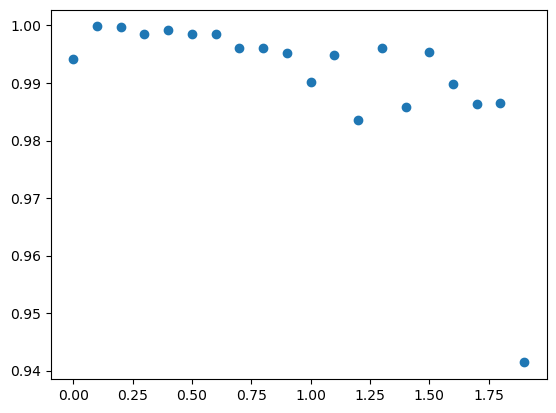

In [10]:
plt.scatter(x,M)
plt.show()

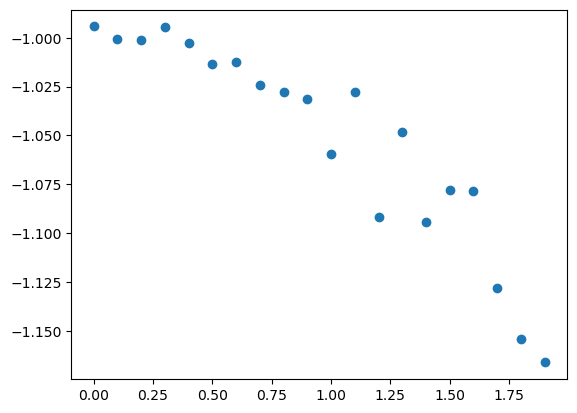

In [11]:
plt.scatter(x,E)
plt.show()

In [77]:
a = np.arange(15).reshape(3,5);
a1 = a/np.trace(a);
a2 = a/np.linalg.norm(a);
a3 = a/np.max(a);

In [81]:
np.linalg.norm(a3)

2.275647474581999

In [75]:
np.linalg.norm(a)

31.85906464414798

In [76]:
np.max(a)

14

In [81]:
D = 4;
d = 2;
T = np.random.rand(D,d,D,d)
nrm_T = ncon([T,T.conj()], [[1,2,3,4],[1,2,3,4]])
T2 = T/np.max(np.abs(T))
np.linalg.norm(T2)

4.548398402897128

In [82]:
np.max(T2)

1.0